# Aligning using the affine transform and cropping

Sections of code adopted from [openface](https://github.com/cmusatyalab/openface/blob/master/openface/align_dlib.py).

In [3]:
import numpy as np
import cv2
import aligndlib as adl
import matplotlib.pyplot as plt
import os
from sklearn.externals import joblib

In [2]:
cv2.__version__

'4.0.0'

In [3]:
pred_path = '/home/prathamesh/undergrad/btech_proj/misc/openface/testing/shape_predictor_68_face_landmarks.dat'

In [5]:
def rect_to_bb(rect):
    # take a bounding predicted by dlib and convert it
    # to the format (x, y, w, h) as we would normally do
    # with OpenCV
    x = rect.left()
    y = rect.top()
    w = rect.right() - x
    h = rect.bottom() - y
 
    # return a tuple of (x, y, w, h)
    return (x, y, w, h)

In [7]:
#Generate cropped and affine aligned images

al = adl.AlignDlib(pred_path)
out_path = '/home/prathamesh/undergrad/btech_proj/misc/openface/pc_demo/Photos/aligned/all/'
empty = []
os.chdir('/home/prathamesh/undergrad/btech_proj/misc/openface/pc_demo/Photos/Group/')
un_aligned = []

for _ in range(197):
    img = cv2.imread(os.getcwd() + '/' + str(_) + '.jpg')
    bbx = al.getAllFaceBoundingBoxes(img)
    if bbx == None:
        empty.append(_)
    else:
        j = 0
        for _crp in bbx:
            (x, y, w, h) = rect_to_bb(_crp)
            if x <= 0 or y <= 0 or w <= 0 or h <= 0:
                print('skipped'+str(_), x, y, w, h)
                continue
            aldimg = al.align(96, img, bb=_crp)
            cv2.imwrite(out_path + str(_) + '_'+ str(j) + '.jpg', aldimg.astype('uint8'))
            j = j + 1

skipped70 -184 1963 1533 1380
skipped167 -24 952 100 90


# Evaluating embedding distances

In [3]:
from sklearn.externals import joblib

In [7]:
cbook = joblib.load('/home/prathamesh/undergrad/btech_proj/misc/openface/pc_demo/face_dict.sav')
cbook[0]

['vedant1',
 'h_kale',
 'prathameshM',
 'affprathamesh',
 'affmahajan',
 'affkale',
 'akkvedant']

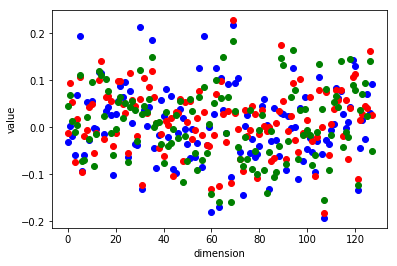

In [12]:
# affine clusters

plt.plot(range(128), cbook[1][3].reshape(128),'bo', range(128), cbook[1][4].reshape(128),'ro', range(128), cbook[1][5].reshape(128), 'go')
plt.xlabel('dimension')
plt.ylabel('value')
plt.show()

In [35]:
# cross class embeddings
import pre_proc as prep
import post_proc as popr
import facenet

model = facenet.load_model()

in_path = '/home/prathamesh/undergrad/btech_proj/resources/DBs/VGG2/test/n000009/'
cross_dist = [[] for _ in range(len(cbook[0]))]

for _ in os.listdir(in_path):
    img = cv2.imread(in_path + _)
    res1, img = prep.face_crop(img, affine=True)
    if res1:
        embd = facenet.forward(model, img.reshape(96, 96, 3)).reshape(1,128)
        for i in range(len(cbook[0])):
            cross_dist[i].append(popr.relative_dist(cbook[1][i], embd))
            

<function matplotlib.pyplot.show(*args, **kw)>

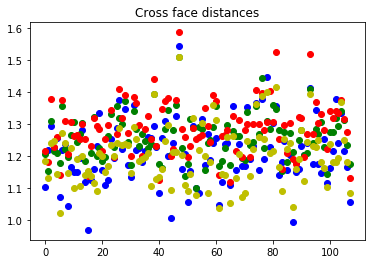

In [36]:
plt.plot(range(len(cross_dist[0])), cross_dist[3], 'bo', range(len(cross_dist[0])), cross_dist[4], 'go', range(len(cross_dist[0])), cross_dist[5], 'ro', range(len(cross_dist[0])), cross_dist[6], 'yo')
plt.title('Cross face distances')
plt.show

In [33]:
# Distance from 

pth1 = '/home/prathamesh/undergrad/btech_proj/misc/openface/pc_demo/Photos/aligned/'
import facenet

model = facenet.load_model()

dis1 = [popr.relative_dist(facenet.forward(model, cv2.imread(pth1 + 'pm/' + em).reshape(96,96,3)).reshape(1,128), cbook[1][3])  for em in os.listdir(pth1 + 'pm/')]
dis2 = [popr.relative_dist(facenet.forward(model, cv2.imread(pth1 + 'hk/' + em).reshape(96,96,3)).reshape(1,128), cbook[1][5])  for em in os.listdir(pth1 + 'hk/')]
dis3 = [popr.relative_dist(facenet.forward(model, cv2.imread(pth1 + 'hm/' + em).reshape(96,96,3)).reshape(1,128), cbook[1][4])  for em in os.listdir(pth1 + 'hm/')]
dis4 = [popr.relative_dist(facenet.forward(model, cv2.imread(pth1 + 'vd/' + em).reshape(96,96,3)).reshape(1,128), cbook[1][6])  for em in os.listdir(pth1 + 'vd/')]



<function matplotlib.pyplot.show(*args, **kw)>

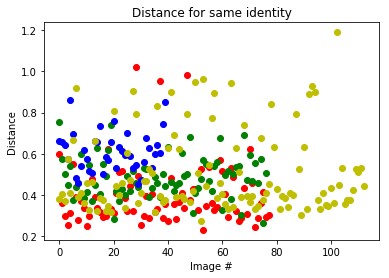

In [34]:
plt.plot(range(len(dis1)), dis1, 'ro', range(len(dis2)), dis2, 'go', range(len(dis3)), dis3, 'bo', range(len(dis4)), dis4, 'yo')
plt.title('Distance for same identity')
plt.xlabel('Image #')
plt.ylabel('Distance')
plt.show

# Evaulating embeddings from 2 different models and their compatibility

In [30]:
import pre_proc as prep
import post_proc as popr
import facenet

sm1 = joblib.load('/home/prathamesh/undergrad/btech_proj/misc/openface/pc_demo/codebooks/small1.sav')
sm2 = joblib.load('/home/prathamesh/undergrad/btech_proj/misc/openface/pc_demo/codebooks/small2.sav')

mdel_path = '/home/prathamesh/undergrad/btech_proj/misc/openface/pc_demo/models/'
mdel1, mdel2 = 'nn4.small1.v1.t7', 'nn4.small2.v1.t7'

model1, model2 = facenet.load_model(model_path=mdel_path + mdel1), facenet.load_model(model_path=mdel_path + mdel2)

In [31]:
def dist_from_avg(avg, path_to_imgs, model, prep=False, affine=False, _plot=True):
    
    dis = []
    
    for _ in os.listdir(path_to_imgs):
        img = cv2.imread(path_to_imgs + _).reshape(96,96,3)
        dis.append(popr.relative_dist(facenet.forward(model, img).reshape(1,128), avg))
    if _plot:
        plt.plot(range(len(dis)), dis, 'ro')
        plt.show
        
    return dis

In [32]:
proj_path = '/home/prathamesh/undergrad/btech_proj/misc/openface/pc_demo/'
img_path = proj_path + 'Photos/aligned/' 
sm2[0], sm1[0]

(['affprathamesh', 'affkale', 'affmahajan', 'affvedant'],
 ['affprathamesh', 'affkale', 'affmahajan', 'affvedant'])

<function matplotlib.pyplot.show(*args, **kw)>

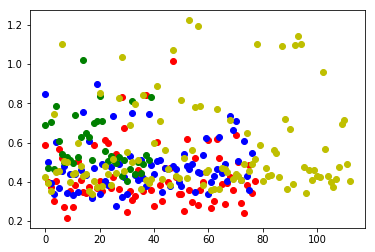

In [38]:
# Evaulating small1(bigger) model
dists = []

for indx, nm in zip(range(4), ['/pm/','/hk/','/hm/','/vd/']):
    dists.append(dist_from_avg(sm1[1][indx], img_path + nm, model1, _plot=False))
    
    
plt.plot(range(len(dists[0])), dists[0], 'ro', range(len(dists[1])), dists[1], 'bo', range(len(dists[2])), dists[2], 'go', range(len(dists[3])), dists[3], 'yo')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

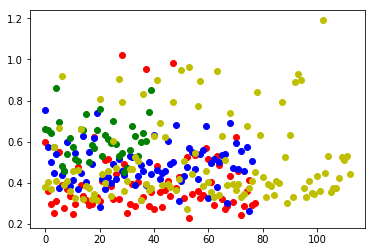

In [39]:
# Evaulating small2(smaller) model

dists = []

for indx, nm in zip(range(4), ['/pm/','/hk/','/hm/','/vd/']):
    dists.append(dist_from_avg(sm2[1][indx], img_path + nm, model2, _plot=False))
    
    
plt.plot(range(len(dists[0])), dists[0], 'ro', range(len(dists[1])), dists[1], 'bo', range(len(dists[2])), dists[2], 'go', range(len(dists[3])), dists[3], 'yo')
plt.show

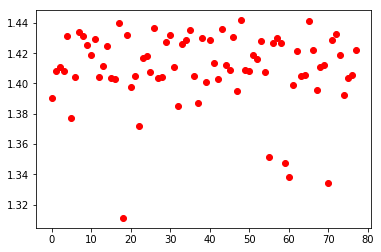

In [43]:
# Distance of embeddings from model1 from average of model2

dist_from_avg(sm1[1][0], img_path + '/pm/', model2, _plot=True)
print()